# Inspect DDI Train data to test rules

Notebook to test Parser, rules and features for the DDI Train dataset.

> NOTE: StanfordCoreNLP needs to be running on a terminal before using the noteboo. Use the following command:
```bash
java -mx4g -cp 'resources/stanford-corenlp/*' edu.stanford.nlp.pipeline.StanfordCoreNLPServer
```

In [4]:
# !/usr/bin/python3
from graphviz import Digraph
from nltk.parse.corenlp import CoreNLPDependencyParser
from os import listdir, system, path, makedirs
from xml.dom.minidom import parse
from tqdm import tqdm
import pickle
import pandas as pd

In [5]:
inputdir = "data/Train"
outputfile = "data/tmp/task9.2_BASELINE_999.txt"
DependencyParser = CoreNLPDependencyParser(url="http://localhost:9000")
import DDI_ML as ddi

In [16]:
training_data = []
entities = {}
files = listdir(inputdir)
for f in tqdm(files[:24]):
    # Parse XML file
    sentences = ddi.parseXML(f"{inputdir}/{f}")
    for s in sentences[:]:
        # get sentence id/text
        sid = s.attributes["id"].value
        stext = s.attributes["text"].value
        if not stext:  # Do not process if sentence is empty
            continue

        # load sentence entities into a dictionary
        ents = s.getElementsByTagName("entity")
        for e in ents:
            id = e.attributes["id"].value
            offs = e.attributes["charOffset"].value.split("-")
            text = e.attributes["text"].value
            entities[id] = {"offset": offs, "text": text}

#         # Tokenize, tag, and parse sentence
        analysis = ddi.analyze(stext)
        
#         verbs = sorted(
#             [analysis.nodes[n] for n in analysis.nodes if "VB" in analysis.nodes[n]["tag"]],
#             key=lambda x: x["head"]
#         )
#         verb = verbs[0] if len(verbs) else None
        verb = None

        training_data.append((sid, stext, verb))

100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


--------------------------------------
--------------------------------------
--------------------------------------

In [7]:
with open("resources/train_goldDDI.txt","r") as fp:
    lines = fp.readlines()
ents = [line.replace("\n","").split("|") for line in lines]
ents

df = pd.DataFrame(ents, columns=["sentence","e1","e2","is_DDI","DDI_type"])
print(df.shape)
df.groupby("DDI_type").size()

(2703, 5)


DDI_type
advise        119
effect        162
int             2
mechanism     201
null         2219
dtype: int64

In [8]:
df_ddi = df[df["DDI_type"] != "null"]
sents = df_ddi["sentence"].values
df_ddi.head()

,sentence,e1,e2,is_DDI,DDI_type
0,DDI-DrugBank.d481.s0,DDI-DrugBank.d481.s0.e0,DDI-DrugBank.d481.s0.e1,1,mechanism
8,DDI-MedLine.d63.s4,DDI-MedLine.d63.s4.e0,DDI-MedLine.d63.s4.e1,1,effect
13,DDI-MedLine.d63.s4,DDI-MedLine.d63.s4.e2,DDI-MedLine.d63.s4.e3,1,effect
14,DDI-MedLine.d63.s5,DDI-MedLine.d63.s5.e0,DDI-MedLine.d63.s5.e1,1,effect
15,DDI-MedLine.d63.s6,DDI-MedLine.d63.s6.e0,DDI-MedLine.d63.s6.e1,1,effect


In [9]:
_data = [[t[0], t[1], t[2]["lemma"] if t[2] else None] for t in training_data]
df_verb = pd.DataFrame(_data, columns=["sentence","text","verb"])
for i in df_verb:
    print(df_verb.text, )
df_verb.head()

0       Interactions between Betaseron and other drugs...
1       Although studies designed to examine drug inte...
2       Betaseron administration to three cancer patie...
3       Differential regulation of tyrosine phosphoryl...
4       The homodimeric disintegrin contortrostatin wa...
                              ...                        
6033    Lovastatin therapy has not been associated wit...
6034    Propranolol: In normal volunteers, there was n...
6035    Digoxin: In patients with hypercholesterolemia...
6036    Oral Hypoglycemic Agents: In pharmacokinetic s...
6037    May interact with addictive medications, espec...
Name: text, Length: 6038, dtype: object
0       Interactions between Betaseron and other drugs...
1       Although studies designed to examine drug inte...
2       Betaseron administration to three cancer patie...
3       Differential regulation of tyrosine phosphoryl...
4       The homodimeric disintegrin contortrostatin wa...
                              ..

,sentence,text,verb
0,DDI-DrugBank.d10.s0,Interactions between Betaseron and other drugs...,None
1,DDI-DrugBank.d10.s1,Although studies designed to examine drug inte...,None
2,DDI-DrugBank.d10.s2,Betaseron administration to three cancer patie...,None
3,DDI-MedLine.d69.s0,Differential regulation of tyrosine phosphoryl...,None
4,DDI-MedLine.d69.s1,The homodimeric disintegrin contortrostatin wa...,None


In [10]:
df = df_ddi.merge(df_verb.iloc[:,:-1], on="sentence", how="inner")
df.sort_values(by="DDI_type", inplace=True)
df["e1"] = df["e1"].apply(lambda x: entities[x]["text"])
df["e2"] = df["e2"].apply(lambda x: entities[x]["text"])
df.head()

,sentence,e1,e2,is_DDI,DDI_type,text


--------------------------------------
-------------------------------------
-------------------------------------
------------------------------------

In [11]:
mechanism = df[df["DDI_type"] == "mechanism"]
row = mechanism.sample(1, random_state=44)
print(row["sentence"].values)
print(row["text"].values)
print(row["e1"].values)
print(row["e2"].values)
analysis = ddi.analyze(row["text"].values[0])
analysis

ValueError: a must be greater than 0 unless no samples are taken

In [12]:
n0 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d430.s0.e0")
n1 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d430.s0.e1")
n0, n1

NameError: name 'analysis' is not defined

In [10]:
v0 = ddi.get_verb_ancestor(analysis, n0)
v1 = ddi.get_verb_ancestor(analysis, n1)
v0, v1

({'address': 4,
  'word': 'shown',
  'lemma': 'show',
  'ctag': 'VBN',
  'tag': 'VBN',
  'feats': '_',
  'head': 0,
  'deps': defaultdict(list,
              {'nsubjpass': [2], 'auxpass': [3], 'xcomp': [6], 'punct': [12]}),
  'rel': 'ROOT'},
 {'address': 6,
  'word': 'double',
  'lemma': 'double',
  'ctag': 'VB',
  'tag': 'VB',
  'feats': '_',
  'head': 4,
  'deps': defaultdict(list, {'mark': [5], 'dobj': [8]}),
  'rel': 'xcomp'})

In [11]:
[v1["address"]] in v0["deps"].values()

True

-----------------------------------
-----------------------------------
-----------------------------------
-----------------------------------

['DDI-DrugBank.d400.s5']
['This interaction should be given consideration in patients taking NSAIDs concomitantly with ACE inhibitors.']
['NSAIDs']
['ACE inhibitors']


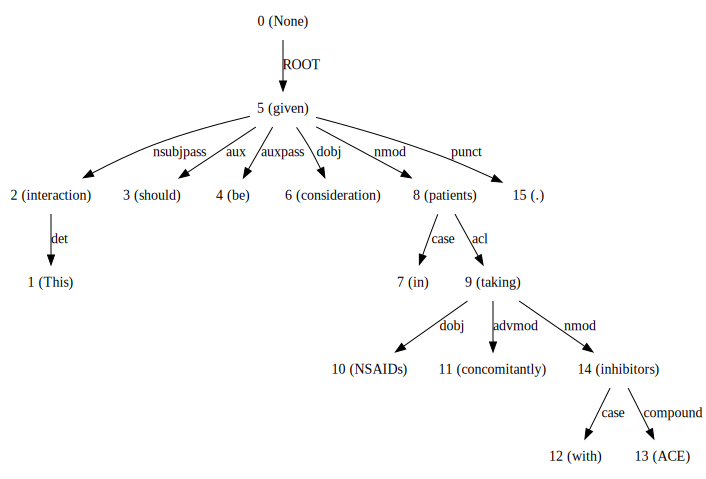

In [21]:
advise = df[df["DDI_type"] == "advise"]
row = advise.sample(1, random_state=42)
print(row["sentence"].values)
print(row["text"].values)
print(row["e1"].values)
print(row["e2"].values)
analysis = ddi.analyze(row["text"].values[0])
analysis

In [13]:
n0 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d400.s5.e0")
n1 = ddi.get_entity_node(analysis, entities, "DDI-DrugBank.d400.s5.e1")
v0 = ddi.get_verb_ancestor(analysis, n0)
v1 = ddi.get_verb_ancestor(analysis, n1)
n0, n1, v0, v1

({'address': 10,
  'word': 'NSAIDs',
  'lemma': 'nsaid',
  'ctag': 'NNS',
  'tag': 'NNS',
  'feats': '_',
  'head': 9,
  'deps': defaultdict(list, {}),
  'rel': 'dobj'},
 {'address': 14,
  'word': 'inhibitors',
  'lemma': 'inhibitor',
  'ctag': 'NNS',
  'tag': 'NNS',
  'feats': '_',
  'head': 9,
  'deps': defaultdict(list, {'case': [12], 'compound': [13]}),
  'rel': 'nmod'},
 {'address': 9,
  'word': 'taking',
  'lemma': 'take',
  'ctag': 'VBG',
  'tag': 'VBG',
  'feats': '_',
  'head': 8,
  'deps': defaultdict(list, {'dobj': [10], 'advmod': [11], 'nmod': [14]}),
  'rel': 'acl'},
 {'address': 9,
  'word': 'taking',
  'lemma': 'take',
  'ctag': 'VBG',
  'tag': 'VBG',
  'feats': '_',
  'head': 8,
  'deps': defaultdict(list, {'dobj': [10], 'advmod': [11], 'nmod': [14]}),
  'rel': 'acl'})

In [14]:
e0_dobj = ddi.get_dependency_address(v0, "dobj") == n0["address"]
e1_nmod = ddi.get_dependency_address(v1, "nmod") == n1["address"]
e0_dobj_nmod_e1 = e0_dobj and e1_nmod
e0_dobj_nmod_e1

True

In [23]:
modal_vb = ["can", "could", "may", "might", "must", "will", "would",
                "shall", "should"]
modal_present = any(
    len([n for n in analysis.nodes if analysis.nodes[n]["word"] is not None and modal in analysis.nodes[n]["tag"]])
    for modal in modal_vb
)
modal_present

True